In [112]:
import sqlite3
import pandas as pd
from scipy.stats import chisquare

In [113]:
conn = sqlite3.connect("db.sqlite")
cursor = conn.cursor()

In [114]:
df = pd.read_csv("data.csv")
# Преобразуем дату для удобной работы в SQLite3
df["MomentPassedUtc"] = pd.to_datetime(df["MomentPassedUtc"])
df["MomentPassedUtc"] = df["MomentPassedUtc"].dt.strftime('%Y-%m-%d %H:%M:%S')
df.to_sql("sessions", conn, if_exists="replace", index=False, dtype={"MomentPassedUtc": "DATETIME"})

1254

In [115]:
def query(sql: str) -> pd.DataFrame:
    return pd.read_sql(sql, conn)

## Вводные данные
__Описание данных__: 
- В данных события открытия контента пользователями приложения, где:
    - `Id`: Идентификатор записи;
    - `UserGuid`: Идентификатор пользователя;
    - `SessionSysname`: Идентификатор сессии;
    - `PsyRequestFilterSysname`: Идентификатор запроса, по которому выдается контент определенного типа;
    - `ContentSysname`: Идентификатор контента;
    - `ViewId`: Идентификатор просмотра (если есть);
    - `MomentPassedUtc`: Временная метка открытия контента;
    - `ContentType`: Тип контента;
    - `TestResultGuid`: Идентификатор результата теста (если есть);
    	

__Вопросы__:
1. [x] Какая единица контента наиболее востребована пользователями, обоснуйте;
2. [x] Контент по какому запросу наиболее востребован пользователями, обоснуйте;
3. [x] Проверьте гипотезу о равномерности распределения запросов;
4. [x] Если считать, что суточное время потребления контента - это разница между открытием первой (по времени вхождения) единицы контента и последней (по времени вхождения) единицы контента в пределах одного дня, то рассчитайте:
    - [х] Среднее суточное время потребления контента для каждого пользователя;
    - [x] Общее среднее суточное время потребления контента для всех пользователей;
    - [x] Выведите таблицу со следующими столбцами: ID пользователя (1), среднее суточное время юзера (2), среднее суточное время общее (3), отклонение (2) от (3);

Решение присылайте в гугл.док с SQL кодом и обоснованиями, таблицы в csv. Проверка гипотезы (п.3) любым доступным инструментом (код или алгоритм проверки приложить).

## Ответы на вопросы и выводы

__Вопрос 1: Какая единица контента наиболее востребована пользователями, обоснуйте.__
Из 16 уникальных единиц контента наиболее востребованная (считаем по количеству `MomentPassedUtc`) – self-esteem-1. 288 открытий (22.97% от всех открытий). Анализ данных показал, что в 50% `ViewId` содержит пропуски в данных. Возможно, что это следствие какой-то ошибки в доставке данных, стоит изучить данный вопрос более детально.   

__Вопрос 2: Контент по какому запросу наиболее востребован пользователями, обоснуйте.__
Из 4 уникальных типов запросов `PsyRequestFilterSysname` (считаем по количеству `MomentPassedUtc`) самый популярный – self-esteem. 628 запросов (50.08%).

__Вопрос 3: Проверьте гипотезу о равномерности распределения запросов.__
Гипотезу о равномерности распределения запросов (`PsyRequestFilterSysname`) проверил с помощью статистического теста Chi-squared. Результаты говорят о том, что нулевую гипотезу (Н0) необходимо отклонить, данные распределены __не равномерно__.   

__Вопрос 4.1: Среднее суточное время потребления контента для каждого пользователя.__
Подробный расчет данной метрики и графики см. в соответствующем разделе ниже, а здесь хочу обратить внимание, что 49% пользователей (в рамках рассматриваемых данных) имеют среднесуточную длительность просмотра контента - 0 секунд. Кажется, с этим надо что-то делать :)  

__Вопрос 4.2: Общее среднее суточное время потребления контента для всех пользователей__
37 минут – общее среднее суточное время потребления конткнта для всех пользователей

__Вопрос 4.3: Выведите таблицу со следующими столбцами: ID пользователя (1), среднее суточное время юзера (2), среднее суточное время общее (3), отклонение (2) от (3)__
Таблица и код собирающий ее в соответствующем разделе ниже. 

## Решение

### Вопрос 1: Какая единица контента наиболее востребована пользователями, обоснуйте.
Для ответа на данный вопрос посчитаем количество открытий `ContentSysname` по `MomentPassedUtc`. Была идея использовать `ViewId` вместо `MomentPassedUtc`, но пропуски в данных в половине случаев (~50,87%) не позволяют это сделать. 

In [116]:
sql = """
SELECT
    ContentSysname, 
    COUNT(MomentPassedUtc) AS cnt,
    ROUND(COUNT(MomentPassedUtc) * 1.0 / sum(Count(MomentPassedUtc)) OVER () * 100, 2) AS percent
FROM sessions
GROUP BY ContentSysname
ORDER BY cnt DESC;
"""
query(sql)

,ContentSysname,cnt,percent
0,self-esteem-1,288,22.97
1,self-esteem-2,134,10.69
2,self-esteem-3,110,8.77
3,self-esteem-4,96,7.66
4,anxiety-1,89,7.10
5,coach-1,87,6.94
6,anxiety-2,69,5.50
7,coach-2,63,5.02
8,Aggressive-1,62,4.94
9,coach-3,54,4.31


### Вопрос 2: Контент по какому запросу наиболее востребован пользователями, обоснуйте.

In [117]:
sql = """
SELECT
    PsyRequestFilterSysname, 
    COUNT(MomentPassedUtc) AS cnt,
    ROUND(COUNT(MomentPassedUtc) * 1.0 / SUM(COUNT(MomentPassedUtc)) OVER () * 100, 2) AS percent
FROM sessions
GROUP BY PsyRequestFilterSysname
ORDER BY cnt DESC;
"""
query(sql)

,PsyRequestFilterSysname,cnt,percent
0,self-esteem,628,50.08
1,coach,255,20.33
2,anxiety,238,18.98
3,Aggressive,133,10.61


### Вопрос 3: Проверьте гипотезу о равномерности распределения запросов
Для проверки равномерности распределения запросов (`PsyRequestFilterSysname`) используем статистический тест Chi-squared:
- В SQL-запросе подготовим данные и получим данные по категориям запросов: observed_freq expected_freq;
- В Python, с помощью библиотеки SciPy проведем сам тест;

In [118]:
sql = """
SELECT PsyRequestFilterSysname,
       COUNT(MomentPassedUtc) AS observed_freq,
       (1.0 * SUM(COUNT(MomentPassedUtc)) OVER ()
            / SUM(COUNT(DISTINCT PsyRequestFilterSysname)) OVER ()
        ) as expected_freq
FROM sessions
GROUP BY PsyRequestFilterSysname
ORDER BY observed_freq DESC;
"""
data = query(sql)
data

,PsyRequestFilterSysname,observed_freq,expected_freq
0,self-esteem,628,313.5
1,coach,255,313.5
2,anxiety,238,313.5
3,Aggressive,133,313.5


In [119]:
chi2_stat, p_value = chisquare(data["observed_freq"], f_exp=data["expected_freq"])

In [120]:
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")
alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу: данные распределены не равномерно")
else:
    print("Не удается отклонить нулевую гипотезу: данные распределены равномерно")

Chi-squared statistic: 448.5263157894737
P-value: 6.80059810854733e-97
Отклоняем нулевую гипотезу: данные распределены не равномерно


### Вопрос 4.1: Среднее суточное время потребления контента для каждого пользователя.

In [121]:
sql = """
WITH
    daily_usage AS (
        SELECT
            UserGuid,
            DATE(MomentPassedUtc) AS date,
            MIN(MomentPassedUtc) AS first_view,
            MAX(MomentPassedUtc) AS last_view,
            TIMEDIFF(MAX(MomentPassedUtc), MIN(MomentPassedUtc)) as day_view,
            ROUND((JULIANDAY(MAX(MomentPassedUtc)) - JULIANDAY(MIN(MomentPassedUtc))) * 86400) AS day_view_seconds
        FROM sessions
        GROUP BY UserGuid, date
        ORDER BY UserGuid, date)

SELECT
    UserGuid, ROUND((sum(day_view_seconds) / count(date)) / 60)  as avg_daily_view_minutes
FROM daily_usage
GROUP BY UserGuid
ORDER BY avg_daily_view_minutes DESC;
"""
data = query(sql)
data

,UserGuid,avg_daily_view_minutes
0,E69CB268-3EE8-47CF-BAC1-90C109ABCA61,566.0
1,F544B3E7-88E1-4113-ACEC-56E331BBA568,299.0
2,F4101711-52B6-434A-8FD6-0C2838A4959D,289.0
3,9DC2E544-01EB-44E3-8433-663D99F3F038,241.0
4,9F1EDCC1-3F28-4074-BA45-773A77CED9BB,184.0
...,...,...
221,0A0DA621-F429-4322-A449-84BA8BAC503A,0.0
222,07FAAFCD-12F8-4757-8B06-7811AF7FDA87,0.0
223,069C5F69-94EB-4690-86A2-76854D11CC9C,0.0
224,0462D50D-DBAD-4F09-9383-2E2479734B98,0.0


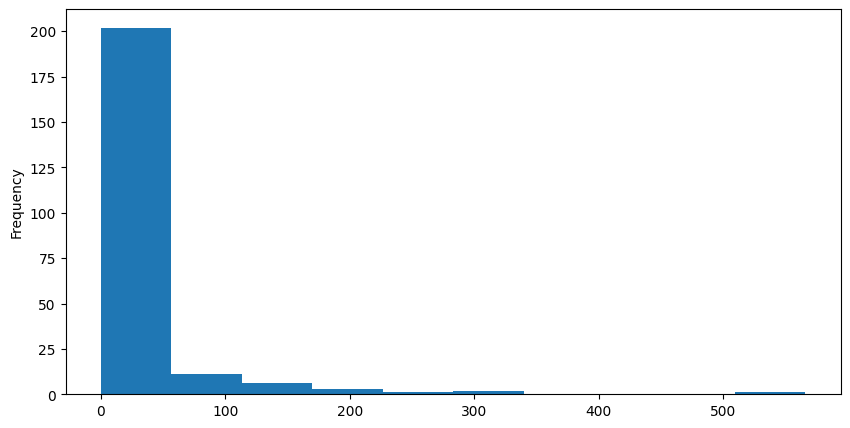

In [122]:
data["avg_daily_view_minutes"].plot(kind="hist", figsize=(10, 5));

In [123]:
data["avg_daily_view_minutes"].value_counts(normalize=True)

avg_daily_view_minutes
0.0      0.491150
1.0      0.101770
2.0      0.039823
4.0      0.039823
3.0      0.026549
5.0      0.026549
8.0      0.013274
53.0     0.008850
9.0      0.008850
12.0     0.008850
13.0     0.008850
14.0     0.008850
18.0     0.008850
23.0     0.008850
25.0     0.008850
26.0     0.008850
43.0     0.008850
98.0     0.004425
10.0     0.004425
17.0     0.004425
16.0     0.004425
15.0     0.004425
123.0    0.004425
126.0    0.004425
143.0    0.004425
11.0     0.004425
147.0    0.004425
113.0    0.004425
167.0    0.004425
7.0      0.004425
176.0    0.004425
179.0    0.004425
184.0    0.004425
241.0    0.004425
289.0    0.004425
119.0    0.004425
110.0    0.004425
97.0     0.004425
51.0     0.004425
89.0     0.004425
77.0     0.004425
73.0     0.004425
69.0     0.004425
64.0     0.004425
54.0     0.004425
101.0    0.004425
48.0     0.004425
104.0    0.004425
299.0    0.004425
40.0     0.004425
39.0     0.004425
38.0     0.004425
37.0     0.004425
36.0     0.004425
28.0 

### Вопрос 4.2: Общее среднее суточное время потребления контента для всех пользователей.

In [124]:
sql = """
WITH
    daily_usage AS (
        SELECT
            UserGuid,
            DATE(MomentPassedUtc) AS date,
            MIN(MomentPassedUtc) AS first_view,
            MAX(MomentPassedUtc) AS last_view,
            TIMEDIFF(MAX(MomentPassedUtc), MIN(MomentPassedUtc)) AS day_view,
            ROUND((JULIANDAY(MAX(MomentPassedUtc)) - JULIANDAY(MIN(MomentPassedUtc))) * 86400) AS day_view_seconds
        FROM sessions
        GROUP BY UserGuid, date
        ORDER BY UserGuid, date
    )

SELECT
    ROUND(sum(day_view_seconds) / count(UserGuid) / 60) AS avg_total_minutes
FROM daily_usage;

"""
query(sql)

,avg_total_minutes
0,37.0


### Вопрос 4.3: Выведите таблицу со следующими столбцами: ID пользователя (1), среднее суточное время юзера (2), среднее суточное время общее (3), отклонение (2) от (3).

In [125]:
sql = """
WITH
    daily_usage AS (
        SELECT
            UserGuid,
            DATE(MomentPassedUtc) AS date,
            MIN(MomentPassedUtc) AS first_view,
            MAX(MomentPassedUtc) AS last_view,
            TIMEDIFF(MAX(MomentPassedUtc), MIN(MomentPassedUtc)) AS day_view,
            ROUND((JULIANDAY(MAX(MomentPassedUtc)) - JULIANDAY(MIN(MomentPassedUtc))) * 86400) AS day_view_seconds
        FROM sessions
        GROUP BY UserGuid, date
        ORDER BY UserGuid, date
    ),

    users_avg AS (
        SELECT
            UserGuid, ROUND((sum(day_view_seconds) / count(date)) / 60)  AS avg_daily_view_minutes
        FROM daily_usage
        GROUP BY UserGuid
        ORDER BY avg_daily_view_minutes DESC
    ),

    total_avg AS (
        SELECT
            ROUND(sum(day_view_seconds) / count(UserGuid) / 60) AS avg_total_minutes
        FROM daily_usage
    )

SELECT
    u.UserGuid,
    u.avg_daily_view_minutes AS avg_daily_minutes_by_user,
    t.avg_total_minutes AS avg_daily_minutes_by_total,
    u.avg_daily_view_minutes - t.avg_total_minutes AS deviation
FROM users_avg as u
LEFT JOIN total_avg as t
"""
query(sql)

,UserGuid,avg_daily_minutes_by_user,avg_daily_minutes_by_total,deviation
0,E69CB268-3EE8-47CF-BAC1-90C109ABCA61,566.0,37.0,529.0
1,F544B3E7-88E1-4113-ACEC-56E331BBA568,299.0,37.0,262.0
2,F4101711-52B6-434A-8FD6-0C2838A4959D,289.0,37.0,252.0
3,9DC2E544-01EB-44E3-8433-663D99F3F038,241.0,37.0,204.0
4,9F1EDCC1-3F28-4074-BA45-773A77CED9BB,184.0,37.0,147.0
...,...,...,...,...
221,0A0DA621-F429-4322-A449-84BA8BAC503A,0.0,37.0,-37.0
222,07FAAFCD-12F8-4757-8B06-7811AF7FDA87,0.0,37.0,-37.0
223,069C5F69-94EB-4690-86A2-76854D11CC9C,0.0,37.0,-37.0
224,0462D50D-DBAD-4F09-9383-2E2479734B98,0.0,37.0,-37.0
